In [5]:
import networkx as nx
from numpy.linalg import matrix_power
import numpy as np
import matplotlib.pyplot as plt
import copy as cp

In [6]:
def isklburnable(g, k, l):
    '''
    g: graph with networkx form
    k: number of sources
    l: number of rounds
    '''
    
    ############################################ Step0: get information
    N = nx.number_of_nodes(g)
    g_copy = cp.deepcopy(g)
    
    ''' '''
    #tip1: uncomment to draw origin graph
    print("0刚开始： input graph")
    nx.draw(g, with_labels=True, font_weight='bold')
    plt.show()
    ''' '''
    ########################################### Step1: get L
    L_list, cut = getL(g, N, l, k)
    
    print(cut)
    if cut == False:
        return np.array(L_list[0]), True
    
    '''
    Or return true
    #? what if L[0] is initially empty?
    if len(L_list[0]) == 0:
        L_list[0] = L_list[1] 
    '''
    ########################################### Step2: initial
    source = -1*np.ones(k) #burnding sequence
    bestsequence = [[], 0] #1st entry: burning sequence; 2nd: number of burned nodes by this bs
    
    R_dynamic = [cp.copy(L_list[0])]
    burned = []
    level_burned = [] 
    
    print("2.0 初始化前： ")
    print("source", source)
    print("R", R_dynamic)
    print("\n")
    
    burned, source, level_burned, R_dynamic = updateR(k, L_list, g, 0, burned, source, level_burned, R_dynamic)
    
    print("2.1 初始化后： ")
    print("source1", source)
    print("R1", R_dynamic)
    print("burned", burned)
    print("level_burned", level_burned)
    print("\n")
    
    ########################################### Step3: loop   
    while len(R_dynamic) != 0:
        
        while len(R_dynamic[k - 1]) != 0:
            source[k - 1] = R_dynamic[k - 1][0] # pick 1st 
            R_dynamic[k-1].remove(R_dynamic[k - 1][0]) #remove 1st
        
            burned.append(source[k-1]) 
            B = burned
        
            #burned B for rest rounds
            for rest_rounds in range(l - k + 1):
                B = findB(B, g)
                if len(B) == N:
                    return source, True
            
            burned.remove(source[k-1])
            
            if bestsequence[1] < len(B):
                bestsequence[0] = source    
                 
        R_dynamic.remove(R_dynamic[k - 1])         
        #level_burned.remove(level_burned[k-1])
        
        burned, source, level_burned, R_dynamic = updateR(k, L_list, g, k-2, burned, source, level_burned, R_dynamic)   
        #(k, L_list, g, num, burned, source, level_burned, R_dynamic):
    return bestsequence[0], False
    


In [11]:
def getL(g, N, l, k):
    L_list = [[x for x in g.nodes()]]
    #L_list = [[x for x in g.nodes() if g.degree(x)<=1]]
    cut = True
    num_remove = 0
    
    gl = cp.deepcopy(g) #used for l
    initial = range(N) 
    for i in range(l - 1):
        leaves = updateL(initial, gl)
        print(leaves)
        initial = cp.deepcopy(leaves)
        L_list.append(initial)
    L_list.reverse()
    
    print("1st", L_list)
    
    #TODO: fix1 initial empty
    
    while(len(L_list[0]) == 0):
      L_list.remove(L_list[0])
      #the second could only be 0, 1 or 2
      cut = False
      num_remove = num_remove + 1
      
    
    print("2nd", L_list)
    #TODO: fix3 edge case ~ 0 in 1st block, 2 in 2nd block
    '''
    if len(L_list) == k - 1:
      L_list.insert(1, L_list[1])
    print("3rd", L_list)
    '''
    
    #only get 1st k rows
    '''
    if len(L_list) > k:
      if num_remove + 1 < len(L_list[0]):
        cut = True
    '''
    
    print("1得到L")
    print(L_list)
    print("\n")
    
    return L_list, cut

def updateL(input, g):#S1 get all leaves
    temp = [x for x in g.nodes() if g.degree(x)<=1] 
    #print("temp", temp)
    #TODO:fix 2 <= 1 single node with degree 0
    
  #S2.1 remove leaves from graph
    for i in range(len(temp)): 
      g.remove_node(temp[i])
  #S2.2 return all non-leaves 
    return [x for x in input if x not in temp]

In [8]:
def findB(burned, gg):
    '''
        input: 
        a) burned: list of burned nodes
        b) gg: total graph
        output:
        nodes_burned_till_this_round
    '''
    nodes_burned_till_this_round = cp.copy(burned)
    # find all bunred vertice's neignbors
    for this_node in burned:
        nb_of_source = nx.all_neighbors(gg, this_node)
            
        for x in nb_of_source:
            if x not in nodes_burned_till_this_round: # keep unique
                nodes_burned_till_this_round.append(x)
    
    return nodes_burned_till_this_round #返回B set

In [13]:
def updateR(k, L_list, g, num, burned, source, level_burned, R_dynamic):
    # 0 judge and recursion
        
    print("2.0+: inside updateR")
    print("在第几层：", num)
    print("source", source)
    print("R", R_dynamic)
    print("burned", burned)
    print("level_burned", level_burned)
    print("\n")
    
    if len(R_dynamic[num]) == 0: #this row does not exist
        if num == 0:
            R_dynamic.remove(R_dynamic[num])
            return burned, source, level_burned, R_dynamic
            #或者直接停/return best
        else:
        # Walk up
            R_dynamic.remove(R_dynamic[num])
            level_burned.remove(level_burned[num - 1])
            #upburned will replace burned
            upburned = []
            for i in level_burned:
                upburned = upburned + i
            
            print("2.0+a go up")
            print("R", R_dynamic)
            print("burned", upburned)
            print("level_burned", level_burned)
            print("\n")
            
            updateR(k, L_list, g, num - 1, upburned, source, level_burned, R_dynamic)
  
        
    # 1. pick burn and remove 
    source[num] = R_dynamic[num][0]
    R_dynamic[num].remove(R_dynamic[num][0])
    old_burned = cp.copy(burned)
    burned.append(source[num])
    
    print("2.0++: pick source, modify R, burned")
    print("1 source", source)
    print("2 R should remove", R_dynamic)
    print("3 burned", burned)
    # 2. update R
    # 2.1 get all burned nodes(B) in this round
    B = findB(burned, g)

        
    # PS: 也可以让findB只返回新burn的vertices
    # 2.2 burn
    if len(level_burned) == 0:
        level_burned.append(B)
    else:
        level_burned.append([node for node in B if node not in old_burned])
    burned = B #update burn
    
            
    print("4 B/new burned", B)
    print("5 level_burned", level_burned)
    
    # 2.2 get L/B and update to the total R
    temp = [node for node in L_list[num + 1] if node not in B]
    
    # deal with empty R
    if len(temp) == 0:
        
        for inner_num in range(num + 2, len(L_list)): #choose L - 1
            temp = [node for node in L_list[inner_num] if node not in B]
            if len(temp) != 0:
                break
            
            if inner_num == len(L_list) - 1:
                return "I don't know"
            
    R_dynamic.append(temp)
        
    print("6 R should add", R_dynamic)
    print("\n")
    
    
    # 3. Walk down: if have not reach the k-1 level， to next level(0, 1, ..., k-2, k-1)
    if num < k - 2: #TODO: deal with new change of L_list (and num < len(L_list) - 2)
        print("2.0+b go down")
        updateR(k, L_list, g, num + 1, burned, source, level_burned, R_dynamic)
            
    return burned, source, level_burned, R_dynamic

In [49]:
g1 = nx.random_tree(9)
g2 = nx.random_tree(9)
g3 = nx.random_tree(9)
g4 = nx.random_tree(9)

0刚开始： input graph


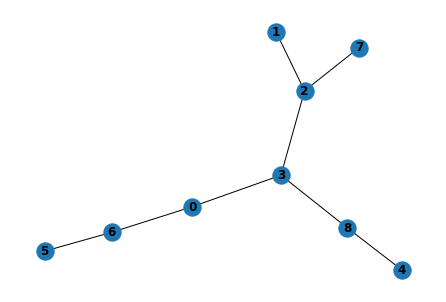

temp [1, 4, 5, 7]
[0, 2, 3, 6, 8]
temp [2, 6, 8]
[0, 3]
temp [0, 3]
[]
1st [[], [0, 3], [0, 2, 3, 6, 8], [1, 4, 5, 7]]
2nd [[0, 3], [0, 2, 3, 6, 8], [1, 4, 5, 7]]
3rd [[0, 3], [0, 2, 3, 6, 8], [1, 4, 5, 7]]
1得到L
[[0, 3], [0, 2, 3, 6, 8], [1, 4, 5, 7]]


2.0 初始化前： 
source [-1. -1. -1.]
R [[0, 3]]


2.0+: inside updateR
在第几层： 0
source [-1. -1. -1.]
R [[0, 3]]
burned []
level_burned []


2.0++: pick source, modify R, burned
1 source [ 0. -1. -1.]
2 R should remove [[3]]
3 burned [0.0]
4 B/new burned [0.0, 6, 3]
5 level_burned [[0.0, 6, 3]]
6 R should add [[3], [2, 8]]


2.0+b go down
2.0+: inside updateR
在第几层： 1
source [ 0. -1. -1.]
R [[3], [2, 8]]
burned [0.0, 6, 3]
level_burned [[0.0, 6, 3]]


2.0++: pick source, modify R, burned
1 source [ 0.  2. -1.]
2 R should remove [[3], [8]]
3 burned [0.0, 6, 3, 2.0]
4 B/new burned [0.0, 6, 3, 2.0, 5, 8, 1, 7]
5 level_burned [[0.0, 6, 3, 2.0], [2.0, 5, 8, 1, 7]]
6 R should add [[3], [8], [4]]


2.1 初始化后： 
source1 [ 0.  2. -1.]
R1 [[3], [8], [4]]
b

In [124]:
#

'''
ans3 = isklburnable(g3, 3, 3)
ans4 = isklburnable(g4, 3, 3)
ans2 = isklburnable(g2, 3, 3)
'''
ans1 = isklburnable(g1, 3, 3)
print(ans1)

In [87]:
gg1 = nx.random_tree(16)
gg2 = nx.random_tree(16)
gg3 = nx.random_tree(16)
gg4 = nx.random_tree(16)

0刚开始： input graph


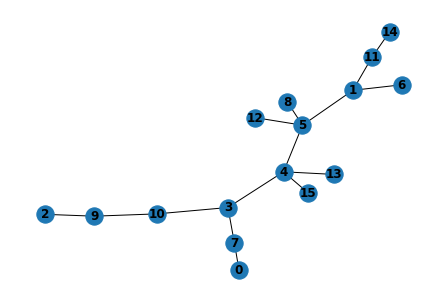

[1, 3, 4, 5, 7, 9, 10, 11]
[1, 3, 4, 5, 10]
[3, 4, 5]
1st [[3, 4, 5], [1, 3, 4, 5, 10], [1, 3, 4, 5, 7, 9, 10, 11], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]]
2nd [[3, 4, 5], [1, 3, 4, 5, 10], [1, 3, 4, 5, 7, 9, 10, 11], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]]
1得到L
[[3, 4, 5], [1, 3, 4, 5, 10], [1, 3, 4, 5, 7, 9, 10, 11], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]]


False


(array([3, 4, 5]), True)

In [10]:
gg5 = nx.random_tree(16)

'''
isklburnable(gg3, 4, 4)
isklburnable(gg4, 4, 4)
'''
#isklburnable(gg1, 4, 4)
isklburnable(gg5, 4, 4)


In [15]:
f1 = nx.random_tree(25)

0刚开始： input graph


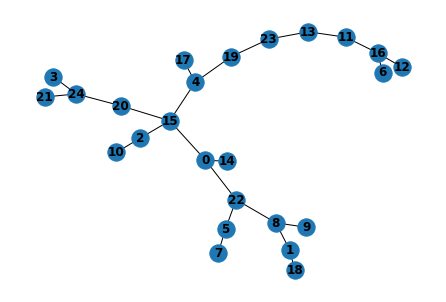

[0, 1, 2, 4, 5, 8, 11, 13, 15, 16, 19, 20, 22, 23, 24]
[0, 4, 8, 11, 13, 15, 19, 20, 22, 23]
[0, 4, 13, 15, 19, 22, 23]
[0, 4, 15, 19, 23]
1st [[0, 4, 15, 19, 23], [0, 4, 13, 15, 19, 22, 23], [0, 4, 8, 11, 13, 15, 19, 20, 22, 23], [0, 1, 2, 4, 5, 8, 11, 13, 15, 16, 19, 20, 22, 23, 24], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]]
2nd [[0, 4, 15, 19, 23], [0, 4, 13, 15, 19, 22, 23], [0, 4, 8, 11, 13, 15, 19, 20, 22, 23], [0, 1, 2, 4, 5, 8, 11, 13, 15, 16, 19, 20, 22, 23, 24], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]]
1得到L
[[0, 4, 15, 19, 23], [0, 4, 13, 15, 19, 22, 23], [0, 4, 8, 11, 13, 15, 19, 20, 22, 23], [0, 1, 2, 4, 5, 8, 11, 13, 15, 16, 19, 20, 22, 23, 24], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]]


True
2.0 初始化前： 
source [-1. -1. -1. -1.]
R [[0, 4, 15, 19, 23]]


2.0+: inside updateR
在第几层： 0
source [-1. -1. -1. -1.]
R [[0, 4, 15, 19, 

(array([ 0.,  4., 13.,  1.]), True)

In [16]:
isklburnable(f1, 4, 5)